In [1]:
import timeit
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import gzip
import os
from six.moves import urllib
from six.moves import xrange 
import math
from tensorflow.python.framework import ops;
import argparse;
import pickle;
from datetime import datetime
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import candidate_sampling_ops
from tensorflow.python.ops import embedding_ops
from tensorflow.python.ops import gen_nn_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import variables
import time
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
def maybe_download(filename, work_directory):
  """Download the data from Yann's website, unless it's already here."""
  if not os.path.exists(work_directory):
    os.mkdir(work_directory)
  filepath = os.path.join(work_directory, filename)
  if not os.path.exists(filepath):
    filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  return filepath
def _read32(bytestream):
  dt = np.dtype(np.uint32).newbyteorder('>')
  return np.frombuffer(bytestream.read(4), dtype=dt)[0]
def extract_images(filename):
  """Extract the images into a 4D uint8 numpy array [index, y, x, depth]."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    magic = _read32(bytestream)
    if magic != 2051:
      raise ValueError('Invalid magic number %d in MNIST image file: %s' %(magic, filename))
    num_images = _read32(bytestream)
    rows = _read32(bytestream)
    cols = _read32(bytestream)
    buf = bytestream.read(rows * cols * num_images)
    data = np.frombuffer(buf, dtype=np.uint8)
    data = data.reshape(num_images, rows, cols, 1)
    return data
def dense_to_one_hot(labels_dense, num_classes=10):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot
def extract_labels(filename, one_hot=False):
  """Extract the labels into a 1D uint8 numpy array [index]."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    magic = _read32(bytestream)
    if magic != 2049:
      raise ValueError('Invalid magic number %d in MNIST label file: %s' %(magic, filename))
    num_items = _read32(bytestream)
    buf = bytestream.read(num_items)
    labels = np.frombuffer(buf, dtype=np.uint8)
    if one_hot:
      return dense_to_one_hot(labels)
    return labels
class DataSet(object):
  def __init__(self, images, labels, fake_data=False):
    if fake_data:
      self._num_examples = 10000
    else:
      assert images.shape[0] == labels.shape[0], ("images.shape: %s labels.shape: %s" % (images.shape,labels.shape))
      self._num_examples = images.shape[0]
      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      assert images.shape[3] == 1
      images = images.reshape(images.shape[0],images.shape[1] * images.shape[2])
      # Convert from [0, 255] -> [0.0, 1.0].
      images = images.astype(np.float32)
      images = np.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0
  @property
  def images(self):
    return self._images
  @property
  def labels(self):
    return self._labels
  @property
  def num_examples(self):
    return self._num_examples
  @property
  def epochs_completed(self):
    return self._epochs_completed
  def next_batch(self, batch_size, fake_data=False):
    """Return the next `batch_size` examples from this data set."""
    if fake_data:
      fake_image = [1.0 for _ in xrange(784)]
      fake_label = 0
      return [fake_image for _ in xrange(batch_size)], [
          fake_label for _ in xrange(batch_size)]
    start = self._index_in_epoch
    self._index_in_epoch += batch_size
    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Shuffle the data
      perm = np.arange(self._num_examples)
      np.random.shuffle(perm)
      self._images = self._images[perm]
      self._labels = self._labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch
    return self._images[start:end], self._labels[start:end]
def read_data_sets(train_dir, fake_data=False, one_hot=False):
  class DataSets(object):
    pass
  data_sets = DataSets()
  if fake_data:
    data_sets.train = DataSet([], [], fake_data=True)
    data_sets.validation = DataSet([], [], fake_data=True)
    data_sets.test = DataSet([], [], fake_data=True)
    return data_sets
  TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
  TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
  TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
  TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
  VALIDATION_SIZE = 5000
  local_file = maybe_download(TRAIN_IMAGES, train_dir)
  train_images = extract_images(local_file)
  local_file = maybe_download(TRAIN_LABELS, train_dir)
  train_labels = extract_labels(local_file, one_hot=one_hot)
  local_file = maybe_download(TEST_IMAGES, train_dir)
  test_images = extract_images(local_file)
  local_file = maybe_download(TEST_LABELS, train_dir)
  test_labels = extract_labels(local_file, one_hot=one_hot)
  validation_images = train_images[:VALIDATION_SIZE]
  validation_labels = train_labels[:VALIDATION_SIZE]
  train_images = train_images[VALIDATION_SIZE:]
  train_labels = train_labels[VALIDATION_SIZE:]
  data_sets.train = DataSet(train_images, train_labels)
  data_sets.validation = DataSet(validation_images, validation_labels)
  data_sets.test = DataSet(test_images, test_labels)
  return data_sets

In [3]:
class LogisticRegression(object):
    '''Multi-class logistic regression class'''
    def __init__(self, inpt, n_in, n_out):
        '''
        inpt: tf.Tensor, (one minibatch) [None, n_in]
        n_in: int, number of input units
        n_out: int, number of output units
        '''
        # weight
        self.W = tf.Variable(tf.zeros([n_in, n_out], dtype=tf.float32))
        # bias
        self.b = tf.Variable(tf.zeros([n_out]), dtype=tf.float32)
        # activation output
        self.output = tf.nn.softmax(tf.matmul(inpt, self.W) + self.b)
        # prediction
        self.y_pred = tf.argmax(self.output, axis=1)
        # keep track of variables
        self.params = [self.W, self.b]

    def cost(self, y):
        '''
        y: tf.Tensor, the target of the input
        '''
        # cross_entropy
        return -tf.reduce_mean(tf.reduce_sum(y * tf.log(self.output), axis=1))

    def accuarcy(self, y):
        '''errors'''
        correct_pred = tf.equal(self.y_pred, tf.argmax(y, axis=1))
        return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [4]:
class dpLogisticRegression(object):
    '''Multi-class logistic regression class'''
    def __init__(self, inpt, n_in, n_out, LaplaceNoise):
        '''
        inpt: tf.Tensor, (one minibatch) [None, n_in]
        n_in: int, number of input units
        n_out: int, number of output units
        LaplaceNoise: Laplace noise
        '''
        # weight
        self.W = tf.Variable(tf.truncated_normal([n_in, n_out], stddev=0.1), dtype=tf.float32, name="W")
        # bias
        self.b = tf.Variable(tf.zeros([n_out]), dtype=tf.float32)
        # activation output
        inpt = tf.clip_by_value(inpt, 0, 1) # hidden neurons must be bounded in [0, 1], sigmoid activation function does not need this bound
        inpt += LaplaceNoise;
        self.output = tf.matmul(inpt, self.W) + self.b
        # prediction
        self.y_pred = tf.argmax(self.output, axis=1)
        # keep track of variables
        self.params = [self.W, self.b]
    
    def cost(self, y):
        zeros = array_ops.zeros_like(self.output, dtype=self.output.dtype)
        cond = (self.output >= zeros)
        relu_logits = array_ops.where(cond, self.output, zeros)
        neg_abs_logits = array_ops.where(cond, -self.output, self.output)
        #Taylor = math_ops.add(relu_logits - y_conv * y_, math_ops.log1p(math_ops.exp(neg_abs_logits)))
        Taylor = math_ops.add(relu_logits - self.output * y, math.log(2.0) + 0.5*neg_abs_logits + 1.0/8.0*neg_abs_logits**2)
        return Taylor
    
    def accuarcy(self, y):
        '''prediction accuracy'''
        correct_pred = tf.equal(self.y_pred, tf.argmax(y, axis=1))
        return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [5]:
class EncLayer(object):
    '''Typical convolutional layer of MLP'''
    def __init__(self, inpt, n_filter_in, n_filter_out, filter_size, W=None, b=None, activation=tf.nn.sigmoid):
        '''
        :param inpt: input for the layer, i.e., images
        :param n_filter_in: the number of input feature maps
        :param n_filter_out: the number of input feature maps
        :param filter_size: the dimension of convolutional filter [filter_size, filter_size]
        '''
        # Initialize parameters: W and b
        if W is None:
            W = tf.Variable(tf.truncated_normal([filter_size, filter_size, n_filter_in, n_filter_out], stddev=0.1), dtype=tf.float32, name="W")
        if b is None:
            b = tf.Variable(tf.zeros([n_filter_out]), dtype=tf.float32, name="b")
        self.W = W
        self.b = b
        self.input = inpt;
        # the output
        sum_W = tf.add(tf.nn.conv2d(inpt, self.W, strides=[1, 2, 2, 1], padding='SAME'), self.b)
        self.output = activation(sum_W) if activation is not None else sum_W
        # the input's shape
        self.inputShape = inpt.get_shape().as_list()
        # params of the layers
        self.params = [self.W, self.b]
            
    # define the Chebyshev Polinomial approximation
    def Chebyshev(self, x):
        return (-5*x**7 + 21*x**5 - 35*x**3 + 35*x + 16)/(2.0**5) # L = 7
        #return (-x**3 + 3*x + 2)/(2.0**2) # L = 3
        #return (5*x**5 + 2*x**4 - 14*x**3 - 4*x**2 + 17*x + 10)/(2.0) # L = 5
        #return (-x**2 + 2*x + 3)/(2.0**2) # L = 2
    
    def dpChebyshev(self, x, Delta, epsilon, batch_size):
        coefficients = [-5.0, 21.0, -35.0, 35.0, 16.0] # L = 7
        #coefficients = [-1.0, 3.0, 2.0] # L = 3
        #coefficients = [-1.0, 2.0, 3.0] # L = 2
        #coefficients = [5.0, 2.0, -14.0, -4.0, 17.0, 10.0] # L = 5
        for i in range(0, len(coefficients)):
            perturbFM = np.random.laplace(0.0, 1.0/(epsilon*batch_size), 1).astype(np.float32);
            perturbFM = tf.multiply(perturbFM, Delta);
            coefficients[i] += perturbFM;
        return (tf.multiply(coefficients[0], x**7) + tf.multiply(coefficients[1], x**5) + tf.multiply(coefficients[2], x**3) + tf.multiply(coefficients[3], x**1) + coefficients[4])/(2.0**5) # L = 7
        #return (tf.multiply(coefficients[0], x**3) + tf.multiply(coefficients[1], x) + coefficients[2])/(2.0**2) # L = 3
        #return (tf.multiply(coefficients[0], x**2) + tf.multiply(coefficients[1], x) + coefficients[2])/(2.0**2) # L = 2
        #return (tf.multiply(coefficients[0], x**5) + tf.multiply(coefficients[1], x**4) + tf.multiply(coefficients[2], x**3) + tf.multiply(coefficients[3], x**2) + tf.multiply(coefficients[4], x**1) + coefficients[5])/(2.0) # L = 5
    
    # sampling hidden neurons given visible neurons
    def propup(self, v):
        '''Compute the sigmoid activation for hidden units given visible units'''
        h = tf.add(tf.nn.conv2d(v, self.W, strides=[1, 2, 2, 1], padding='SAME'), self.b)
        # Get the max value of hidden neurons
        max = tf.reduce_max(h)
        # Normalization so that h will satisfy the Riemann integrable condition on [−1, 1]
        h = h/max;
        return tf.clip_by_value(self.Chebyshev(h), 0.0, 1.0) # values of hidden neurons must be bounded [0, 1]

    # differentially private hidden terms given visible neurons
    def dp_propup(self, v, Delta, epsilon, batch_size):
        '''Compute the differentially private activation for hidden terms given visible units'''
        h = tf.add(tf.nn.conv2d(v, self.W, strides=[1, 2, 2, 1], padding='SAME'), self.b)
        max = tf.reduce_max(h)
        h = h/max;
        # hidden neurons have to be bounded in [0, 1] after the perturbation
        Chebyshev_h = tf.clip_by_value(self.dpChebyshev(h, Delta, epsilon, batch_size), 0.0, 1.0)

        return Chebyshev_h # return perturbed approximated polinomial coefficients h
    
    # transpose of convolutional RBM given hidden neurons, this is use for convolutional auto-encoder
    def decode(self, xShape, propup, activation=tf.nn.sigmoid):
        rc_input = activation(tf.add(tf.nn.conv2d_transpose(propup, self.W,
                    tf.stack([xShape, self.inputShape[1], self.inputShape[2], self.inputShape[3]]),
                    strides=[1, 2, 2, 1], padding='SAME'), self.b))
        return rc_input
    
    # reconstruct visible units from convolutional feature maps
    def decode2(self, xShape, propup, activation=tf.nn.sigmoid):
        # upsampling given hidden feature maps to obtain input's size feature maps. This step can be considered an actual deconvolution
        upsample3 = tf.image.resize_images(propup, size=(self.inputShape[1],self.inputShape[2]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        # reconstruct the original inputs
        rc_input = activation(tf.nn.conv2d(input=upsample3, filter=tf.transpose(self.W, perm=[1, 0, 3, 2]), strides=[1, 1, 1, 1], padding='SAME'))
        ###
        return rc_input
    
    # get pre-training objective function, this is use for convolutional auto-encoder
    def get_train_ops(self, xShape, learning_rate=0.1):
        propup = self.propup(self.input)
        rc_v = self.decode(xShape, propup, activation=tf.nn.sigmoid);
        self.cost = tf.reduce_sum(tf.square(rc_v - self.input))
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost, var_list=self.params)
        return optimizer
    
    # get differentially private pre-training energy function for convolutional RBM
    def get_train_ops2(self, xShape, Delta, epsilon = 0.25, batch_size = 3600, learning_rate=0.1):
        # compute h terms
        propup = self.dp_propup(self.input, Delta, epsilon, batch_size)
        # reconstruct v terms
        rc_v = self.decode2(xShape, propup, activation=tf.nn.sigmoid);
        # reconstruct h terms
        rc_propup = self.dp_propup(rc_v, Delta, epsilon, batch_size)
        # minimize the differentially private mean between the two energy functions: (1) contructed from the original input, (2) constructed from the reconstructed input. In other words, we use CD-1 to minimize the energy function.
        self.cost = tf.reduce_mean(tf.abs(rc_propup - propup)) + tf.reduce_mean(tf.abs(rc_v - self.input))
        # define AdamOptimizer optimization
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost, var_list=self.params)
        return optimizer

In [6]:
class ConvLayer(object):
    '''Typical convolutional layer of MLP'''
    def __init__(self, inpt, filter_size, n_in, n_out, W=None, b=None, activation=tf.nn.sigmoid):
        '''
        :param inpt: input for the layer, i.e., images
        :param n_in: the number of input units
        :param n_out: the number of output units
        '''
        if W is None:
            W = tf.Variable(tf.truncated_normal([filter_size, filter_size, n_in, n_out], stddev=0.1), dtype=tf.float32, name="W")
        if b is None:
            b = tf.Variable(tf.zeros([n_out]), dtype=tf.float32, name="b")

        self.W = W
        self.b = b
        # the output
        sum_W = tf.add(tf.nn.conv2d(inpt, self.W, strides=[1, 2, 2, 1], padding='SAME'), self.b)
        self.output = activation(sum_W) if activation is not None else sum_W
        # params
        self.params = [self.W, self.b]

In [7]:
class ConvFlat(object):
    '''Transforming layer from a convolutional layer to a fully connected layer'''
    def __init__(self, inpt, xShape, n_out, activation=tf.nn.sigmoid):
        '''
        inpt: tf.Tensor, (one minibatch) [None, n_in]
        xShape: the first dimention of the input, i.e., used to access the batch_size
        n_out: int, number of output units
        '''
        # Initialize parameters W and b
        shape = inpt.get_shape().as_list()
        n_in = shape[1]*shape[2]*shape[3]
        # weight
        self.W = tf.Variable(tf.truncated_normal([n_in, n_out], stddev=0.1), dtype=tf.float32, name="W")
        # bias
        self.b = tf.Variable(tf.zeros([n_out]), dtype=tf.float32)
        ###
        # Compute the output
        h = tf.reshape(inpt, tf.stack([xShape, n_in]))
        sum_W = tf.matmul(h, self.W) + self.b
        # Applying normalization for the flat connected layer
        batch_mean2, batch_var2 = tf.nn.moments(sum_W,[0])
        scale2 = tf.Variable(tf.ones([n_out]))
        beta2 = tf.Variable(tf.zeros([n_out]))
        BN_norm = tf.nn.batch_normalization(sum_W,batch_mean2,batch_var2,beta2,scale2,1e-3)
        ###
        self.output = activation(BN_norm) if activation is not None else BN_norm
        #####
        # keep track of variables
        self.params = [self.W, self.b]

In [8]:
class HiddenLayer(object):
    '''Typical hidden layer of MLP'''
    def __init__(self, inpt, n_in, n_out, activation=tf.nn.sigmoid):
        '''
        inpt: tf.Tensor, shape [n_examples, n_in]
        n_in: int, the dimensionality of input
        n_out: int, number of hidden units
        W, b: tf.Tensor, weight and bias
        activation: tf.op, activation function
        '''
        # weight
        self.W = tf.Variable(tf.truncated_normal([n_in, n_out], stddev=0.1), dtype=tf.float32, name="W")
        # bias
        self.b = tf.Variable(tf.zeros([n_out]), dtype=tf.float32)
        self.input = inpt;
        # shape
        self.n_in = n_in;
        self.n_out = n_out;
        # the output
        sum_W = tf.matmul(inpt, self.W) + self.b
        self.output = activation(sum_W) if activation is not None else sum_W
        # params
        self.params = [self.W, self.b]


In [9]:
class MLP(object):
    '''Multi-layer perceptron class'''
    def __init__(self, inpt, n_in, n_hidden, n_out):
        '''
        inpt: tf.Tensor, shape [n_examples, n_in]
        n_in: int, the dimensionality of input
        n_hidden: int, number of hidden units
        n_out: int, number of output units
        '''
        # hidden layer
        self.hiddenLayer = HiddenLayer(inpt, n_in=n_in, n_out=n_hidden)
        # output layer (logistic layer)
        self.outputLayer = LogisticRegression(self.hiddenLayer.output, n_in=n_hidden,
                                              n_out=n_out)
        # L1 norm
        self.L1 = tf.reduce_sum(tf.abs(self.hiddenLayer.W)) + \
                  tf.reduce_sum(tf.abs(self.outputLayer.W))
        # L2 norm
        self.L2 = tf.reduce_sum(tf.square(self.hiddenLayer.W)) + \
                  tf.reduce_sum(tf.square(self.outputLayer.W))
        # cross_entropy cost function
        self.cost = self.outputLayer.cost
        # accuracy function
        self.accuracy = self.outputLayer.accuarcy

        # params
        self.params = self.hiddenLayer.params + self.outputLayer.params
        # keep track of input
        self.input = inpt

epochs vs accuracy (training set)

In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import matplotlib.pyplot as plt
#plt.style.use('default')
#fig,ax= plt.subplots()
x_a=[]
y_a=[]
class pCDBN(object):
    '''
    An implement of differentially private convolutional deep belief network
    '''
    def __init__(self, n_in=784, n_out=10, filter_size = 5, hidden_layers_sizes=[10, 10, 25], epsilon = 0.25, _batch_size = 3600, finetuneLR = 0.01):
        '''
        :param n_in: int, the dimension of input
        :param n_out: int, the dimension of output
        :param filter_size: the dimension of convolutional filter [filter_size, filter_size]
        :param hidden_layers_sizes: list or tuple, the number of convolutional feature maps, the last item will be the number of hidden neurons in the last hidden layer
        :param epsilon: privacy budget epsilon
        :param _batch_size: the batch size
        :param finetuneLR: fine tunning learning rate
        '''
        # Number of layers
        assert len(hidden_layers_sizes) > 0
        self.n_layers = len(hidden_layers_sizes)
        self.layers = []    # convolutional and hidden layers
        self.params = []       # keep track of params for training
        self.last_n_in = hidden_layers_sizes[-1] # the number of hidden neurons in the last hidden layer
        self.pretrain_ops = []; # list of pretrain objective functions for convolutional layers
        self.epsilon = epsilon; # privacy budget epsilon epsilon
        self.batch_size = _batch_size; # batch size

        # Define the input, output, Laplace noise for the output layer, and Delta for the pretrain convolutional layers
        self.x = tf.placeholder(tf.float32, shape=[None, n_in], name='x')
        # ensure 2-d is converted to square tensor.
        if len(self.x.get_shape()) == 2:
            x_dim = np.sqrt(self.x.get_shape().as_list()[1])
            if x_dim != int(x_dim):
                raise ValueError('Unsupported input dimensions')
            x_dim = int(x_dim)
            x_tensor = tf.reshape(self.x, [-1, x_dim, x_dim, 1])
        elif len(self.x.get_shape()) == 4:
            x_tensor = self.x
        else:
            raise ValueError('Unsupported input dimensions')
        image = x_tensor
    
        self.y = tf.placeholder(tf.float32, shape=[None, n_out])
        self.LaplaceNoise = tf.placeholder(tf.float32, 25);
        self.Delta = tf.placeholder(tf.float32, 1);
        ######
        
        #############################
        ##Construct the Model########
        #############################
        # Create the 1st convolutional restricted boltzmann layer
        Enc_Layer1 = EncLayer(inpt=image, n_filter_in = 1, n_filter_out = hidden_layers_sizes[0], filter_size = 5, activation=tf.nn.sigmoid)
        self.layers.append(Enc_Layer1)
        self.params.extend(Enc_Layer1.params)
        # get the pretrain objective function
        self.pretrain_ops.append(Enc_Layer1.get_train_ops2(xShape = tf.shape(image)[0], Delta = self.Delta, epsilon = self.epsilon, batch_size = self.batch_size, learning_rate= 0.01))
        ###
        
        # Create the 2nd convolutional restricted boltzmann layer
        Enc_Layer2 = EncLayer(inpt=self.layers[-1].output, n_filter_in = hidden_layers_sizes[0], n_filter_out = hidden_layers_sizes[1], filter_size = 5, activation=tf.nn.sigmoid)
        self.layers.append(Enc_Layer2)
        self.params.extend(Enc_Layer2.params)
        # get the pretrain objective function
        self.pretrain_ops.append(Enc_Layer2.get_train_ops2(xShape = tf.shape(image)[0], Delta = self.Delta, epsilon = self.epsilon, batch_size = self.batch_size, learning_rate= 0.01))
        ###
        
        # Create the flat connected hidden layer
        flat1 = ConvFlat(inpt=self.layers[-1].output, xShape = tf.shape(image)[0], n_out = self.last_n_in, activation=tf.nn.relu)
        self.layers.append(flat1)
        self.params.extend(flat1.params)
        ###
        
        # Create the output layer
        # We use the differentially private Logistic Regression (dpLogisticRegression) layer as the objective function
        self.output_layer = dpLogisticRegression(inpt=self.layers[-1].output, n_in = self.last_n_in, n_out=n_out, LaplaceNoise = self.LaplaceNoise)
        # We can also use the non-differentially private layer: LogisticRegression(inpt=self.layers[-1].output, n_in=hidden_layers_sizes[-1], n_out=n_out)
        self.params.extend(self.output_layer.params)
        ###

        #######################################
        ##Define Fine Tune Cost and Optimizer##
        #######################################
        # The finetuning cost
        self.cost = self.output_layer.cost(self.y)
        # train_op for finetuning with AdamOptimizer
        global_step = tf.Variable(0, trainable=False)
        #learning_rate = tf.train.exponential_decay(finetuneLR, global_step, 700, 0.96, staircase=True); # learning rate decay can be carefully used
        # Fine tune with AdamOptimizer. Note that we do not fine tune the pre-trained parameters at the convolutional layers
        self.train_op = tf.train.AdamOptimizer(finetuneLR).minimize(self.cost, var_list=[flat1.params, self.output_layer.params], global_step = global_step)
        # The accuracy
        self.accuracy = self.output_layer.accuarcy(self.y)
        ###
        
    def getDelta(self, v, W, b):
        # Set _W and _b to be 1 with the shape of W and b
        _W = tf.constant(1.0, shape=W.get_shape())
        _b = tf.constant(1.0, shape=b.get_shape())
        ###
        # Compute hidden neurons in the convolutional layer
        h = tf.add(tf.nn.conv2d(v, _W, strides=[1, 2, 2, 1], padding='SAME'), _b)
        # Get the max value of hidden neurons
        max = tf.reduce_max(h)
        # Normalization so that h will satisfy the Riemann integrable condition on [−1, 1]
        h = h/max;
        # Approxiate hidden neurons by using Chebyshev Polinomial Approximations
        Chebyshev_h = tf.clip_by_value(EncLayer.Chebyshev(self = self, x = h), 0.0, 1.0)
        # Compute the global sensitivity Delta
        Delta = 2.0*tf.reduce_max(tf.abs(tf.reduce_sum(Chebyshev_h, axis=[1, 2])))
        # Compute max(v_terms)
        v_shape = v.get_shape().as_list()
        if (len(v_shape) > 2):
            Delta += 2.0*tf.reduce_max(tf.abs(tf.reduce_sum(v, axis=[1, 2])))
        else:
            Delta += 2.0*tf.reduce_max(tf.abs(tf.reduce_sum(v, axis=[1])))
        return Delta
    
    def generateNoise(n_in, epsilon, batch_size, test = False):
        Delta = 0.0;
        if test == True: # do not inject noise in the test phase
            Delta = 0.0;
        else:
            Delta = 10*(n_in + 1/4 * n_in**2); # global sensitivity for the output layer, note that 10 is the number of classes of the output layer
        # Generate the Laplace noise
        perturbFM = np.random.laplace(0.0, Delta/(epsilon*batch_size), n_in)
        perturbFM = np.reshape(perturbFM, [n_in]);
        return perturbFM;

    def pretrain(self, sess, X_train, batch_size=3600, pretraining_epochs=3, lr=0.1, k=1,
                    display_step=1):
        '''
        Pretrain the layers (just train the Convolutional RBM layers)
        :param sess: tf.Session
        :param X_train: the input of the train set (You might modify this function if you do not use the designed mnist)
        :param batch_size: int
        :param lr: float
        :param k: int, use CD-k
        :param pretraining_epoch: int
        :param display_step: int
        '''
        print('Starting pretraining...\n')
        start_time = timeit.default_timer()
        batch_num = int(math.ceil(X_train.train.num_examples / batch_size)) # The number of batch per epoch
        # Pretrain layer by layer
        for i in range(self.n_layers-1):
            # Get the cost of the current Convolutional RBM layer
            cost = self.layers[i].cost;
            # Get the objective function of the current Convolutional RBM layer
            train_ops = self.pretrain_ops[i]
            # Get the Delta operation of the current Convolutional RBM layer
            delta = self.getDelta(v = self.layers[i].input, W = self.layers[i].W, b = self.layers[i].b)
            for epoch in range(pretraining_epochs):
                avg_cost = 0.0
                for j in range(batch_num):
                    x_batch, _ = X_train.train.next_batch(batch_size)
                    # Compute the actual Delta with the current parameters of the current Convolutional RBM layer
                    _Delta = delta.eval(session=sess, feed_dict={self.x: x_batch});
                    #print(np.reshape(_Delta, [1]))
                    # training
                    sess.run(train_ops, feed_dict={self.x: x_batch, self.Delta: np.reshape(_Delta, [1])})
                    # cost
                    avg_cost += sess.run(cost, feed_dict={self.x: x_batch, self.Delta: np.reshape(_Delta, [1])}) / batch_num
                # print out the average cost every display_step
                if epoch % display_step == 0:
                    print("\tPretraing layer {0} Epoch {1} cost: {2}".format(i, epoch, avg_cost))

        end_time = timeit.default_timer()
        print("\nThe pretraining process ran for {0} minutes".format((end_time - start_time) / 60))
    
    def finetuning(self, sess, trainSet, training_epochs=200, _epsilon = 0.25, _batch_size = 3600, display_step=10):
        '''
        Finetuing the network
        '''
        print("\nStart finetuning...\n")
        start_time = timeit.default_timer()
        
        for epoch in range(training_epochs):
            #avg_cost = 0.0
            batch_num = int(math.ceil(trainSet.train.num_examples / _batch_size)) # The number of batch per epoch
            for i in range(batch_num):
                x_batch, y_batch = trainSet.train.next_batch(_batch_size)
                # training
                LapNoise = pCDBN.generateNoise(n_in = 25, epsilon = _epsilon, batch_size = _batch_size, test = False); #Add Laplace noise in training
                sess.run(self.train_op, feed_dict={self.x: x_batch, self.y: y_batch, self.LaplaceNoise: LapNoise})
            # print out the average cost
            if epoch % display_step == 0:
                LapNoise = pCDBN.generateNoise(n_in = 25, epsilon = _epsilon, batch_size = _batch_size, test = True); #Do not add noise when testing
                val_acc = sess.run(self.accuracy, feed_dict={self.x: trainSet.validation.images,
                                                       self.y: trainSet.validation.labels, self.LaplaceNoise: LapNoise})
                print("\tEpoch {0} \t validation accuacy: \t {1}".format(epoch, val_acc))
                x_a.append(epoch)
                y_a.append(val_acc)
                #plt.plot(epoch, val_acc, 'ro')
                #print(val_acc)
                #ax.plot(epoch, val_acc)
        end_time = timeit.default_timer()
        print("\nThe finetuning process ran for {0} minutes".format((end_time - start_time) / 60))
        plt.plot(x_a,y_a)
        plt.title("Epochs vs Val_accuracy")
        plt.xlabel("Training epochs")
        plt.ylabel("Val_accuracy")
      

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Starting pretraining...

	Pretraing layer 0 Epoch 0 cost: 0.19998085778206587
	Pretraing layer 0 Epoch 1 cost: 0.17625578958541155
	Pretraing layer 0 Epoch 2 cost: 0.1595443757250905
	Pretraing layer 1 Epoch 0 cost: 0.4363297950476408
	Pretraing layer 1 Epoch 1 cost: 0.265798956155777
	Pretraing layer 1 Epoch 2 cost: 0.1740975696593523

The pretraining process ran for 26.65964349615 minutes

Start finetuning...

	Epoch 0 	 validation accuacy: 	 0.2078000009059906
	Epoch 10 	 validation accuacy: 	 0.7483999729156494
	Epoch 20 	 validation accua

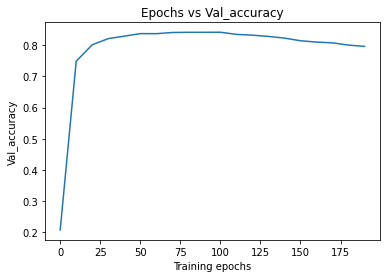

In [11]:
if __name__ == "__main__":
    # mnist examples
    mnist = read_data_sets("MNIST_data/", one_hot=True)
    dbn = pCDBN(n_in=784, n_out=10, filter_size = 5, hidden_layers_sizes=[32, 64, 25], epsilon = 0.2, _batch_size = 3600, finetuneLR = 2e-4)
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    # set random_seed for the reproducibility
    tf.set_random_seed(seed=1111)
    dbn.pretrain(sess, X_train=mnist)
    dbn.finetuning(sess, _epsilon = dbn.epsilon, _batch_size = dbn.batch_size, trainSet=mnist)

epochs vs accuracy (test)

In [12]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
x_a=[]
y_a=[]
class pCDBN(object):
    '''
    An implement of differentially private convolutional deep belief network
    '''
    def __init__(self, n_in=784, n_out=10, filter_size = 5, hidden_layers_sizes=[10, 10, 25], epsilon = 0.25, _batch_size = 3600, finetuneLR = 0.01):
        '''
        :param n_in: int, the dimension of input
        :param n_out: int, the dimension of output
        :param filter_size: the dimension of convolutional filter [filter_size, filter_size]
        :param hidden_layers_sizes: list or tuple, the number of convolutional feature maps, the last item will be the number of hidden neurons in the last hidden layer
        :param epsilon: privacy budget epsilon
        :param _batch_size: the batch size
        :param finetuneLR: fine tunning learning rate
        '''
        # Number of layers
        assert len(hidden_layers_sizes) > 0
        self.n_layers = len(hidden_layers_sizes)
        self.layers = []    # convolutional and hidden layers
        self.params = []       # keep track of params for training
        self.last_n_in = hidden_layers_sizes[-1] # the number of hidden neurons in the last hidden layer
        self.pretrain_ops = []; # list of pretrain objective functions for convolutional layers
        self.epsilon = epsilon; # privacy budget epsilon epsilon
        self.batch_size = _batch_size; # batch size

        # Define the input, output, Laplace noise for the output layer, and Delta for the pretrain convolutional layers
        self.x = tf.placeholder(tf.float32, shape=[None, n_in], name='x')
        # ensure 2-d is converted to square tensor.
        if len(self.x.get_shape()) == 2:
            x_dim = np.sqrt(self.x.get_shape().as_list()[1])
            if x_dim != int(x_dim):
                raise ValueError('Unsupported input dimensions')
            x_dim = int(x_dim)
            x_tensor = tf.reshape(self.x, [-1, x_dim, x_dim, 1])
        elif len(self.x.get_shape()) == 4:
            x_tensor = self.x
        else:
            raise ValueError('Unsupported input dimensions')
        image = x_tensor
    
        self.y = tf.placeholder(tf.float32, shape=[None, n_out])
        self.LaplaceNoise = tf.placeholder(tf.float32, 25);
        self.Delta = tf.placeholder(tf.float32, 1);
        ######
        
        #############################
        ##Construct the Model########
        #############################
        # Create the 1st convolutional restricted boltzmann layer
        Enc_Layer1 = EncLayer(inpt=image, n_filter_in = 1, n_filter_out = hidden_layers_sizes[0], filter_size = 5, activation=tf.nn.sigmoid)
        self.layers.append(Enc_Layer1)
        self.params.extend(Enc_Layer1.params)
        # get the pretrain objective function
        self.pretrain_ops.append(Enc_Layer1.get_train_ops2(xShape = tf.shape(image)[0], Delta = self.Delta, epsilon = self.epsilon, batch_size = self.batch_size, learning_rate= 0.01))
        ###
        
        # Create the 2nd convolutional restricted boltzmann layer
        Enc_Layer2 = EncLayer(inpt=self.layers[-1].output, n_filter_in = hidden_layers_sizes[0], n_filter_out = hidden_layers_sizes[1], filter_size = 5, activation=tf.nn.sigmoid)
        self.layers.append(Enc_Layer2)
        self.params.extend(Enc_Layer2.params)
        # get the pretrain objective function
        self.pretrain_ops.append(Enc_Layer2.get_train_ops2(xShape = tf.shape(image)[0], Delta = self.Delta, epsilon = self.epsilon, batch_size = self.batch_size, learning_rate= 0.01))
        ###
        
        # Create the flat connected hidden layer
        flat1 = ConvFlat(inpt=self.layers[-1].output, xShape = tf.shape(image)[0], n_out = self.last_n_in, activation=tf.nn.relu)
        self.layers.append(flat1)
        self.params.extend(flat1.params)
        ###
        
        # Create the output layer
        # We use the differentially private Logistic Regression (dpLogisticRegression) layer as the objective function
        self.output_layer = dpLogisticRegression(inpt=self.layers[-1].output, n_in = self.last_n_in, n_out=n_out, LaplaceNoise = self.LaplaceNoise)
        # We can also use the non-differentially private layer: LogisticRegression(inpt=self.layers[-1].output, n_in=hidden_layers_sizes[-1], n_out=n_out)
        self.params.extend(self.output_layer.params)
        ###

        #######################################
        ##Define Fine Tune Cost and Optimizer##
        #######################################
        # The finetuning cost
        self.cost = self.output_layer.cost(self.y)
        # train_op for finetuning with AdamOptimizer
        global_step = tf.Variable(0, trainable=False)
        #learning_rate = tf.train.exponential_decay(finetuneLR, global_step, 700, 0.96, staircase=True); # learning rate decay can be carefully used
        # Fine tune with AdamOptimizer. Note that we do not fine tune the pre-trained parameters at the convolutional layers
        self.train_op = tf.train.AdamOptimizer(finetuneLR).minimize(self.cost, var_list=[flat1.params, self.output_layer.params], global_step = global_step)
        # The accuracy
        self.accuracy = self.output_layer.accuarcy(self.y)
        ###
        
    def getDelta(self, v, W, b):
        # Set _W and _b to be 1 with the shape of W and b
        _W = tf.constant(1.0, shape=W.get_shape())
        _b = tf.constant(1.0, shape=b.get_shape())
        ###
        # Compute hidden neurons in the convolutional layer
        h = tf.add(tf.nn.conv2d(v, _W, strides=[1, 2, 2, 1], padding='SAME'), _b)
        # Get the max value of hidden neurons
        max = tf.reduce_max(h)
        # Normalization so that h will satisfy the Riemann integrable condition on [−1, 1]
        h = h/max;
        # Approxiate hidden neurons by using Chebyshev Polinomial Approximations
        Chebyshev_h = tf.clip_by_value(EncLayer.Chebyshev(self = self, x = h), 0.0, 1.0)
        # Compute the global sensitivity Delta
        Delta = 2.0*tf.reduce_max(tf.abs(tf.reduce_sum(Chebyshev_h, axis=[1, 2])))
        # Compute max(v_terms)
        v_shape = v.get_shape().as_list()
        if (len(v_shape) > 2):
            Delta += 2.0*tf.reduce_max(tf.abs(tf.reduce_sum(v, axis=[1, 2])))
        else:
            Delta += 2.0*tf.reduce_max(tf.abs(tf.reduce_sum(v, axis=[1])))
        return Delta
    
    def generateNoise(n_in, epsilon, batch_size, test = False):
        Delta = 0.0;
        if test == True: # do not inject noise in the test phase
            Delta = 0.0;
        else:
            Delta = 10*(n_in + 1/4 * n_in**2); # global sensitivity for the output layer, note that 10 is the number of classes of the output layer
        # Generate the Laplace noise
        perturbFM = np.random.laplace(0.0, Delta/(epsilon*batch_size), n_in)
        perturbFM = np.reshape(perturbFM, [n_in]);
        return perturbFM;

    def pretrain(self, sess, X_train, batch_size=3600, pretraining_epochs=3, lr=0.1, k=1,
                    display_step=1):
        '''
        Pretrain the layers (just train the Convolutional RBM layers)
        :param sess: tf.Session
        :param X_train: the input of the train set (You might modify this function if you do not use the designed mnist)
        :param batch_size: int
        :param lr: float
        :param k: int, use CD-k
        :param pretraining_epoch: int
        :param display_step: int
        '''
        print('Starting pretraining...\n')
        start_time = timeit.default_timer()
        batch_num = int(math.ceil(X_train.test.num_examples / batch_size)) # The number of batch per epoch  -----------------------
        # Pretrain layer by layer
        for i in range(self.n_layers-1):
            # Get the cost of the current Convolutional RBM layer
            cost = self.layers[i].cost;
            # Get the objective function of the current Convolutional RBM layer
            train_ops = self.pretrain_ops[i]
            # Get the Delta operation of the current Convolutional RBM layer
            delta = self.getDelta(v = self.layers[i].input, W = self.layers[i].W, b = self.layers[i].b)
            for epoch in range(pretraining_epochs):
                avg_cost = 0.0
                for j in range(batch_num):
                    x_batch, _ = X_train.test.next_batch(batch_size)  #------------------------------
                    # Compute the actual Delta with the current parameters of the current Convolutional RBM layer
                    _Delta = delta.eval(session=sess, feed_dict={self.x: x_batch});
                    #print(np.reshape(_Delta, [1]))
                    # training
                    sess.run(train_ops, feed_dict={self.x: x_batch, self.Delta: np.reshape(_Delta, [1])})
                    # cost
                    avg_cost += sess.run(cost, feed_dict={self.x: x_batch, self.Delta: np.reshape(_Delta, [1])}) / batch_num
                # print out the average cost every display_step
                if epoch % display_step == 0:
                    print("\tPretraing layer {0} Epoch {1} cost: {2}".format(i, epoch, avg_cost))

        end_time = timeit.default_timer()
        print("\nThe pretraining process ran for {0} minutes".format((end_time - start_time) / 60))
    
    def finetuning(self, sess, trainSet, training_epochs=200, _epsilon = 0.25, _batch_size = 3600, display_step=10):
        '''
        Finetuing the network
        '''
        print("\nStart finetuning...\n")
        start_time = timeit.default_timer()
        
        for epoch in range(training_epochs):
            #avg_cost = 0.0
            batch_num = int(math.ceil(trainSet.test.num_examples / _batch_size)) # The number of batch per epoch  ----------------------------
            for i in range(batch_num):
                x_batch, y_batch = trainSet.test.next_batch(_batch_size)  #----------------------
                # training
                LapNoise = pCDBN.generateNoise(n_in = 25, epsilon = _epsilon, batch_size = _batch_size, test = False); #Add Laplace noise in training
                sess.run(self.train_op, feed_dict={self.x: x_batch, self.y: y_batch, self.LaplaceNoise: LapNoise})
            # print out the average cost
            if epoch % display_step == 0:
                LapNoise = pCDBN.generateNoise(n_in = 25, epsilon = _epsilon, batch_size = _batch_size, test = True); #Do not add noise when testing
                val_acc = sess.run(self.accuracy, feed_dict={self.x: trainSet.validation.images, self.y: trainSet.validation.labels, self.LaplaceNoise: LapNoise}) #--------
                print("\tEpoch {0} \t validation accuacy: \t {1}".format(epoch, val_acc))
                x_a.append(epoch)
                y_a.append(val_acc)
                #plt.plot(epoch, val_acc, 'ro')
                #print(val_acc)
                #ax.plot(epoch, val_acc)
        end_time = timeit.default_timer()
        print("\nThe finetuning process ran for {0} minutes".format((end_time - start_time) / 60))
        plt.plot(x_a,y_a)
        plt.title("Epochs vs Val_accuracy")
        plt.xlabel("Training epochs")
        plt.ylabel("Val_accuracy")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Starting pretraining...

	Pretraing layer 0 Epoch 0 cost: 0.22183305521806085
	Pretraing layer 0 Epoch 1 cost: 0.2152162492275238
	Pretraing layer 0 Epoch 2 cost: 0.20251747965812683
	Pretraing layer 1 Epoch 0 cost: 0.5647542079289755
	Pretraing layer 1 Epoch 1 cost: 0.48142596085866296
	Pretraing layer 1 Epoch 2 cost: 0.4289736052354177

The pretraining process ran for 5.051508249350006 minutes

Start finetuning...

	Epoch 0 	 validation accuacy: 	 0.10040000081062317
	Epoch 10 	 validation accuacy: 	 0.24500000476837158
	Epoch 20 	 validation accuacy: 	 0.391400009393692
	Epoch 30 	 validation accuacy: 	 0.4821999967098236
	Epoch 40 	 validation accuacy: 	 0.5428000092506409
	Epoch 50 	 validation accuacy: 	 0.5953999757766724
	Epoch 60 	 validation accuacy: 	 0.6230000257492065
	Epoch 70 	 va

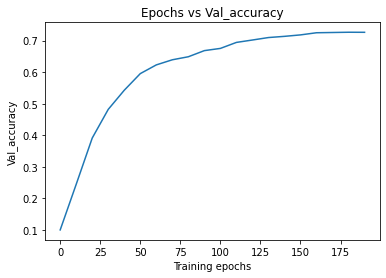

In [13]:
if __name__ == "__main__":
    # mnist examples
    mnist = read_data_sets("MNIST_data/", one_hot=True)
    dbn = pCDBN(n_in=784, n_out=10, filter_size = 5, hidden_layers_sizes=[32, 64, 25], epsilon = 0.2, _batch_size = 3600, finetuneLR = 2e-4)
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    # set random_seed for the reproducibility
    tf.set_random_seed(seed=1111)
    dbn.pretrain(sess, X_train=mnist)
    dbn.finetuning(sess, _epsilon = dbn.epsilon, _batch_size = dbn.batch_size, trainSet=mnist)
    

epsilon vs accuracy

In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
x_a=[]
y_a=[]
class pCDBN(object):
    '''
    An implement of differentially private convolutional deep belief network
    '''
    def __init__(self, n_in=784, n_out=10, filter_size = 5, hidden_layers_sizes=[10, 10, 25], epsilon = 0.25, _batch_size = 3600, finetuneLR = 0.01):
        '''
        :param n_in: int, the dimension of input
        :param n_out: int, the dimension of output
        :param filter_size: the dimension of convolutional filter [filter_size, filter_size]
        :param hidden_layers_sizes: list or tuple, the number of convolutional feature maps, the last item will be the number of hidden neurons in the last hidden layer
        :param epsilon: privacy budget epsilon
        :param _batch_size: the batch size
        :param finetuneLR: fine tunning learning rate
        '''
        # Number of layers
        assert len(hidden_layers_sizes) > 0
        self.n_layers = len(hidden_layers_sizes)
        self.layers = []    # convolutional and hidden layers
        self.params = []       # keep track of params for training
        self.last_n_in = hidden_layers_sizes[-1] # the number of hidden neurons in the last hidden layer
        self.pretrain_ops = []; # list of pretrain objective functions for convolutional layers
        self.epsilon = epsilon; # privacy budget epsilon epsilon
        self.batch_size = _batch_size; # batch size

        # Define the input, output, Laplace noise for the output layer, and Delta for the pretrain convolutional layers
        self.x = tf.placeholder(tf.float32, shape=[None, n_in], name='x')
        # ensure 2-d is converted to square tensor.
        if len(self.x.get_shape()) == 2:
            x_dim = np.sqrt(self.x.get_shape().as_list()[1])
            if x_dim != int(x_dim):
                raise ValueError('Unsupported input dimensions')
            x_dim = int(x_dim)
            x_tensor = tf.reshape(self.x, [-1, x_dim, x_dim, 1])
        elif len(self.x.get_shape()) == 4:
            x_tensor = self.x
        else:
            raise ValueError('Unsupported input dimensions')
        image = x_tensor
    
        self.y = tf.placeholder(tf.float32, shape=[None, n_out])
        self.LaplaceNoise = tf.placeholder(tf.float32, 25);
        self.Delta = tf.placeholder(tf.float32, 1);
        ######
        
        #############################
        ##Construct the Model########
        #############################
        # Create the 1st convolutional restricted boltzmann layer
        Enc_Layer1 = EncLayer(inpt=image, n_filter_in = 1, n_filter_out = hidden_layers_sizes[0], filter_size = 5, activation=tf.nn.sigmoid)
        self.layers.append(Enc_Layer1)
        self.params.extend(Enc_Layer1.params)
        # get the pretrain objective function
        self.pretrain_ops.append(Enc_Layer1.get_train_ops2(xShape = tf.shape(image)[0], Delta = self.Delta, epsilon = self.epsilon, batch_size = self.batch_size, learning_rate= 0.01))
        ###
        
        # Create the 2nd convolutional restricted boltzmann layer
        Enc_Layer2 = EncLayer(inpt=self.layers[-1].output, n_filter_in = hidden_layers_sizes[0], n_filter_out = hidden_layers_sizes[1], filter_size = 5, activation=tf.nn.sigmoid)
        self.layers.append(Enc_Layer2)
        self.params.extend(Enc_Layer2.params)
        # get the pretrain objective function
        self.pretrain_ops.append(Enc_Layer2.get_train_ops2(xShape = tf.shape(image)[0], Delta = self.Delta, epsilon = self.epsilon, batch_size = self.batch_size, learning_rate= 0.01))
        ###
        
        # Create the flat connected hidden layer
        flat1 = ConvFlat(inpt=self.layers[-1].output, xShape = tf.shape(image)[0], n_out = self.last_n_in, activation=tf.nn.relu)
        self.layers.append(flat1)
        self.params.extend(flat1.params)
        ###
        
        # Create the output layer
        # We use the differentially private Logistic Regression (dpLogisticRegression) layer as the objective function
        self.output_layer = dpLogisticRegression(inpt=self.layers[-1].output, n_in = self.last_n_in, n_out=n_out, LaplaceNoise = self.LaplaceNoise)
        # We can also use the non-differentially private layer: LogisticRegression(inpt=self.layers[-1].output, n_in=hidden_layers_sizes[-1], n_out=n_out)
        self.params.extend(self.output_layer.params)
        ###

        #######################################
        ##Define Fine Tune Cost and Optimizer##
        #######################################
        # The finetuning cost
        self.cost = self.output_layer.cost(self.y)
        # train_op for finetuning with AdamOptimizer
        global_step = tf.Variable(0, trainable=False)
        #learning_rate = tf.train.exponential_decay(finetuneLR, global_step, 700, 0.96, staircase=True); # learning rate decay can be carefully used
        # Fine tune with AdamOptimizer. Note that we do not fine tune the pre-trained parameters at the convolutional layers
        self.train_op = tf.train.AdamOptimizer(finetuneLR).minimize(self.cost, var_list=[flat1.params, self.output_layer.params], global_step = global_step)
        # The accuracy
        self.accuracy = self.output_layer.accuarcy(self.y)
        ###
        
    def getDelta(self, v, W, b):
        # Set _W and _b to be 1 with the shape of W and b
        _W = tf.constant(1.0, shape=W.get_shape())
        _b = tf.constant(1.0, shape=b.get_shape())
        ###
        # Compute hidden neurons in the convolutional layer
        h = tf.add(tf.nn.conv2d(v, _W, strides=[1, 2, 2, 1], padding='SAME'), _b)
        # Get the max value of hidden neurons
        max = tf.reduce_max(h)
        # Normalization so that h will satisfy the Riemann integrable condition on [−1, 1]
        h = h/max;
        # Approxiate hidden neurons by using Chebyshev Polinomial Approximations
        Chebyshev_h = tf.clip_by_value(EncLayer.Chebyshev(self = self, x = h), 0.0, 1.0)
        # Compute the global sensitivity Delta
        Delta = 2.0*tf.reduce_max(tf.abs(tf.reduce_sum(Chebyshev_h, axis=[1, 2])))
        # Compute max(v_terms)
        v_shape = v.get_shape().as_list()
        if (len(v_shape) > 2):
            Delta += 2.0*tf.reduce_max(tf.abs(tf.reduce_sum(v, axis=[1, 2])))
        else:
            Delta += 2.0*tf.reduce_max(tf.abs(tf.reduce_sum(v, axis=[1])))
        return Delta
    
    def generateNoise(n_in, epsilon, batch_size, test = False):
        Delta = 0.0;
        if test == True: # do not inject noise in the test phase
            Delta = 0.0;
        else:
            Delta = 10*(n_in + 1/4 * n_in**2); # global sensitivity for the output layer, note that 10 is the number of classes of the output layer
        # Generate the Laplace noise
        perturbFM = np.random.laplace(0.0, Delta/(epsilon*batch_size), n_in)
        perturbFM = np.reshape(perturbFM, [n_in]);
        return perturbFM;

    def pretrain(self, sess, X_train, batch_size=3600, pretraining_epochs=3, lr=0.1, k=1,
                    display_step=1):
        '''
        Pretrain the layers (just train the Convolutional RBM layers)
        :param sess: tf.Session
        :param X_train: the input of the train set (You might modify this function if you do not use the designed mnist)
        :param batch_size: int
        :param lr: float
        :param k: int, use CD-k
        :param pretraining_epoch: int
        :param display_step: int
        '''
        print('Starting pretraining...\n')
        start_time = timeit.default_timer()
        batch_num = int(math.ceil(X_train.test.num_examples / batch_size)) # The number of batch per epoch  -----------------------
        # Pretrain layer by layer
        for i in range(self.n_layers-1):
            # Get the cost of the current Convolutional RBM layer
            cost = self.layers[i].cost;
            # Get the objective function of the current Convolutional RBM layer
            train_ops = self.pretrain_ops[i]
            # Get the Delta operation of the current Convolutional RBM layer
            delta = self.getDelta(v = self.layers[i].input, W = self.layers[i].W, b = self.layers[i].b)
            for epoch in range(pretraining_epochs):
                avg_cost = 0.0
                for j in range(batch_num):
                    x_batch, _ = X_train.test.next_batch(batch_size)  #------------------------------
                    # Compute the actual Delta with the current parameters of the current Convolutional RBM layer
                    _Delta = delta.eval(session=sess, feed_dict={self.x: x_batch});
                    #print(np.reshape(_Delta, [1]))
                    # training
                    sess.run(train_ops, feed_dict={self.x: x_batch, self.Delta: np.reshape(_Delta, [1])})
                    # cost
                    avg_cost += sess.run(cost, feed_dict={self.x: x_batch, self.Delta: np.reshape(_Delta, [1])}) / batch_num
                # print out the average cost every display_step
                if epoch % display_step == 0:
                    print("\tPretraing layer {0} Epoch {1} cost: {2}".format(i, epoch, avg_cost))

        end_time = timeit.default_timer()
        print("\nThe pretraining process ran for {0} minutes".format((end_time - start_time) / 60))
    
    def finetuning(self, sess, trainSet, training_epochs=100, _epsilon = 0.25, _batch_size = 3600, display_step=9):
        '''
        Finetuing the network
        '''
        print("\nStart finetuning...\n")
        start_time = timeit.default_timer()
        
        for epoch in range(training_epochs):
            #avg_cost = 0.0
            batch_num = int(math.ceil(trainSet.test.num_examples / _batch_size)) # The number of batch per epoch  ----------------------------
            for i in range(batch_num):
                x_batch, y_batch = trainSet.test.next_batch(_batch_size)  #----------------------
                # training
                LapNoise = pCDBN.generateNoise(n_in = 25, epsilon = _epsilon, batch_size = _batch_size, test = False); #Add Laplace noise in training
                sess.run(self.train_op, feed_dict={self.x: x_batch, self.y: y_batch, self.LaplaceNoise: LapNoise})
            # print out the average cost
            if epoch % display_step == 0:
                LapNoise = pCDBN.generateNoise(n_in = 25, epsilon = _epsilon, batch_size = _batch_size, test = True); #Do not add noise when testing
                val_acc = sess.run(self.accuracy, feed_dict={self.x: trainSet.validation.images, self.y: trainSet.validation.labels, self.LaplaceNoise: LapNoise}) #--------
                #print("\tEpoch {0} \t validation accuacy: \t {1}".format(epoch, val_acc))
                if epoch==99:
                  print("\tepsilon {0} \t validation accuracy: \t {1}".format(_epsilon,val_acc))
                #x_a.append(epoch)
                #y_a.append(val_acc)
                  x_a.append(_epsilon)
                  y_a.append(val_acc)
                #plt.plot(epoch, val_acc, 'ro')
                #print(val_acc)
                #ax.plot(epoch, val_acc)
        end_time = timeit.default_timer()
        print("\nThe finetuning process ran for {0} minutes".format((end_time - start_time) / 60))
        #plt.plot(x_a,y_a)
        plt.plot(x_a,y_a)
        #plt.title("Epochs vs Val_accuracy")
        plt.title("epsilon vs Val_accuracy")
        #plt.xlabel("Training epochs")
        plt.xlabel("epsilon")
        #plt.ylabel("Val_accuracy")
        plt.ylabel("Val_accuracy")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Starting pretraining...

	Pretraing layer 0 Epoch 0 cost: 0.29218417406082153
	Pretraing layer 0 Epoch 1 cost: 0.2809419631958008
	Pretraing layer 0 Epoch 2 cost: 0.24173040191332495
	Pretraing layer 1 Epoch 0 cost: 0.4463885029157002
	Pretraing layer 1 Epoch 1 cost: 0.3581643005212148
	Pretraing layer 1 Epoch 2 cost: 0.2535982032616933

The pretraining process ran for 5.002673407216662 minutes

Start finetuning...

	epsilon 0.1 	 validation accuracy: 	 0.48579999804496765

The finetuning process ran for 2.646467130000004 minutes
Starting pretraining...

	Pretraing layer 0 Epoch 0 cost: 0.1922091394662857
	Pretraing layer 0 Epoch 1 cost: 0.18635655442873636
	Pretraing layer 0 Epoch 2 cost: 0.18298584719498953
	Pretraing layer 1 Epoch 0 cost: 0.5483849843343098
	Pretraing layer 1 Epoch 1 cost: 0.

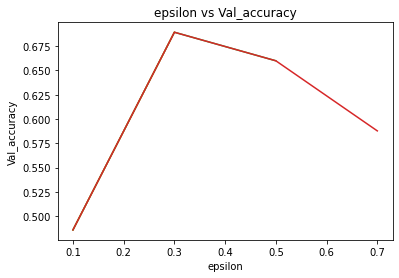

In [15]:
if __name__ == "__main__":
    # mnist examples
    mnist = read_data_sets("MNIST_data/", one_hot=True)
    itrl =[0.1,0.3,0.5,0.7]
    for i in range(len(itrl)):
      dbn = pCDBN(n_in=784, n_out=10, filter_size = 5, hidden_layers_sizes=[32, 64, 25], epsilon = itrl[i], _batch_size = 3600, finetuneLR = 2e-4)
      sess = tf.Session()
      init = tf.global_variables_initializer()
      sess.run(init)
    # set random_seed for the reproducibility
      tf.set_random_seed(seed=1111)
      dbn.pretrain(sess, X_train=mnist)
      dbn.finetuning(sess, _epsilon = dbn.epsilon, _batch_size = dbn.batch_size, trainSet=mnist)

Comparision

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
x_a=[]
y_a=[]
class pCDBN(object):
    '''
    An implement of differentially private convolutional deep belief network
    '''
    def __init__(self, n_in=784, n_out=10, filter_size = 5, hidden_layers_sizes=[10, 10, 25, 25], epsilon = 0.25, _batch_size = 3600, finetuneLR = 0.01):
        '''
        :param n_in: int, the dimension of input
        :param n_out: int, the dimension of output
        :param filter_size: the dimension of convolutional filter [filter_size, filter_size]
        :param hidden_layers_sizes: list or tuple, the number of convolutional feature maps, the last item will be the number of hidden neurons in the last hidden layer
        :param epsilon: privacy budget epsilon
        :param _batch_size: the batch size
        :param finetuneLR: fine tunning learning rate
        '''
        # Number of layers
        assert len(hidden_layers_sizes) > 0
        self.n_layers = len(hidden_layers_sizes)
        self.layers = []    # convolutional and hidden layers
        self.params = []       # keep track of params for training
        self.last_n_in = hidden_layers_sizes[-1] # the number of hidden neurons in the last hidden layer
        self.pretrain_ops = []; # list of pretrain objective functions for convolutional layers
        self.epsilon = epsilon; # privacy budget epsilon epsilon
        self.batch_size = _batch_size; # batch size

        # Define the input, output, Laplace noise for the output layer, and Delta for the pretrain convolutional layers
        self.x = tf.placeholder(tf.float32, shape=[None, n_in], name='x')
        # ensure 2-d is converted to square tensor.
        if len(self.x.get_shape()) == 2:
            x_dim = np.sqrt(self.x.get_shape().as_list()[1])
            if x_dim != int(x_dim):
                raise ValueError('Unsupported input dimensions')
            x_dim = int(x_dim)
            x_tensor = tf.reshape(self.x, [-1, x_dim, x_dim, 1])
        elif len(self.x.get_shape()) == 4:
            x_tensor = self.x
        else:
            raise ValueError('Unsupported input dimensions')
        image = x_tensor
    
        self.y = tf.placeholder(tf.float32, shape=[None, n_out])
        self.LaplaceNoise = tf.placeholder(tf.float32, 25);
        self.Delta = tf.placeholder(tf.float32, 1);
        ######
        
        #############################
        ##Construct the Model########
        #############################
        # Create the 1st convolutional restricted boltzmann layer
        Enc_Layer1 = EncLayer(inpt=image, n_filter_in = 1, n_filter_out = hidden_layers_sizes[0], filter_size = 5, activation=tf.nn.sigmoid)
        self.layers.append(Enc_Layer1)
        self.params.extend(Enc_Layer1.params)
        # get the pretrain objective function
        self.pretrain_ops.append(Enc_Layer1.get_train_ops2(xShape = tf.shape(image)[0], Delta = self.Delta, epsilon = self.epsilon, batch_size = self.batch_size, learning_rate= 0.01))
        ###
        
        # Create the 2nd convolutional restricted boltzmann layer
        Enc_Layer2 = EncLayer(inpt=self.layers[-1].output, n_filter_in = hidden_layers_sizes[0], n_filter_out = hidden_layers_sizes[1], filter_size = 5, activation=tf.nn.sigmoid)
        self.layers.append(Enc_Layer2)
        self.params.extend(Enc_Layer2.params)
        # get the pretrain objective function
        self.pretrain_ops.append(Enc_Layer2.get_train_ops2(xShape = tf.shape(image)[0], Delta = self.Delta, epsilon = self.epsilon, batch_size = self.batch_size, learning_rate= 0.01))
        ###

        Enc_Layer3 = EncLayer(inpt=self.layers[-1].output, n_filter_in = hidden_layers_sizes[1], n_filter_out = hidden_layers_sizes[2], filter_size = 5, activation=tf.nn.sigmoid)
        self.layers.append(Enc_Layer3)
        self.params.extend(Enc_Layer3.params)
        # get the pretrain objective function
        self.pretrain_ops.append(Enc_Layer3.get_train_ops2(xShape = tf.shape(image)[0], Delta = self.Delta, epsilon = self.epsilon, batch_size = self.batch_size, learning_rate= 0.01))
        ###
        
        # Create the flat connected hidden layer
        flat1 = ConvFlat(inpt=self.layers[-1].output, xShape = tf.shape(image)[0], n_out = self.last_n_in, activation=tf.nn.relu)
        self.layers.append(flat1)
        self.params.extend(flat1.params)
        ###
        
        # Create the output layer
        # We use the differentially private Logistic Regression (dpLogisticRegression) layer as the objective function
        self.output_layer = dpLogisticRegression(inpt=self.layers[-1].output, n_in = self.last_n_in, n_out=n_out, LaplaceNoise = self.LaplaceNoise)
        # We can also use the non-differentially private layer: LogisticRegression(inpt=self.layers[-1].output, n_in=hidden_layers_sizes[-1], n_out=n_out)
        self.params.extend(self.output_layer.params)
        ###

        #######################################
        ##Define Fine Tune Cost and Optimizer##
        #######################################
        # The finetuning cost
        self.cost = self.output_layer.cost(self.y)
        # train_op for finetuning with AdamOptimizer
        global_step = tf.Variable(0, trainable=False)
        #learning_rate = tf.train.exponential_decay(finetuneLR, global_step, 700, 0.96, staircase=True); # learning rate decay can be carefully used
        # Fine tune with AdamOptimizer. Note that we do not fine tune the pre-trained parameters at the convolutional layers
        self.train_op = tf.train.AdamOptimizer(finetuneLR).minimize(self.cost, var_list=[flat1.params, self.output_layer.params], global_step = global_step)
        # The accuracy
        self.accuracy = self.output_layer.accuarcy(self.y)
        ###
        
    def getDelta(self, v, W, b):
        # Set _W and _b to be 1 with the shape of W and b
        _W = tf.constant(1.0, shape=W.get_shape())
        _b = tf.constant(1.0, shape=b.get_shape())
        ###
        # Compute hidden neurons in the convolutional layer
        h = tf.add(tf.nn.conv2d(v, _W, strides=[1, 2, 2, 1], padding='SAME'), _b)
        # Get the max value of hidden neurons
        max = tf.reduce_max(h)
        # Normalization so that h will satisfy the Riemann integrable condition on [−1, 1]
        h = h/max;
        # Approxiate hidden neurons by using Chebyshev Polinomial Approximations
        Chebyshev_h = tf.clip_by_value(EncLayer.Chebyshev(self = self, x = h), 0.0, 1.0)
        # Compute the global sensitivity Delta
        Delta = 2.0*tf.reduce_max(tf.abs(tf.reduce_sum(Chebyshev_h, axis=[1, 2])))
        # Compute max(v_terms)
        v_shape = v.get_shape().as_list()
        if (len(v_shape) > 2):
            Delta += 2.0*tf.reduce_max(tf.abs(tf.reduce_sum(v, axis=[1, 2])))
        else:
            Delta += 2.0*tf.reduce_max(tf.abs(tf.reduce_sum(v, axis=[1])))
        return Delta
    
    def generateNoise(n_in, epsilon, batch_size, test = False):
        Delta = 0.0;
        if test == True: # do not inject noise in the test phase
            Delta = 0.0;
        else:
            Delta = 10*(n_in + 1/4 * n_in**2); # global sensitivity for the output layer, note that 10 is the number of classes of the output layer
        # Generate the Laplace noise
        perturbFM = np.random.laplace(0.0, Delta/(epsilon*batch_size), n_in)
        perturbFM = np.reshape(perturbFM, [n_in]);
        return perturbFM;

    def pretrain(self, sess, X_train, batch_size=3600, pretraining_epochs=3, lr=0.1, k=1,
                    display_step=1):
        '''
        Pretrain the layers (just train the Convolutional RBM layers)
        :param sess: tf.Session
        :param X_train: the input of the train set (You might modify this function if you do not use the designed mnist)
        :param batch_size: int
        :param lr: float
        :param k: int, use CD-k
        :param pretraining_epoch: int
        :param display_step: int
        '''
        print('Starting pretraining...\n')
        start_time = timeit.default_timer()
        batch_num = int(math.ceil(X_train.test.num_examples / batch_size)) # The number of batch per epoch  -----------------------
        # Pretrain layer by layer
        for i in range(self.n_layers-1):
            # Get the cost of the current Convolutional RBM layer
            cost = self.layers[i].cost;
            # Get the objective function of the current Convolutional RBM layer
            train_ops = self.pretrain_ops[i]
            # Get the Delta operation of the current Convolutional RBM layer
            delta = self.getDelta(v = self.layers[i].input, W = self.layers[i].W, b = self.layers[i].b)
            for epoch in range(pretraining_epochs):
                avg_cost = 0.0
                for j in range(batch_num):
                    x_batch, _ = X_train.test.next_batch(batch_size)  #------------------------------
                    # Compute the actual Delta with the current parameters of the current Convolutional RBM layer
                    _Delta = delta.eval(session=sess, feed_dict={self.x: x_batch});
                    #print(np.reshape(_Delta, [1]))
                    # training
                    sess.run(train_ops, feed_dict={self.x: x_batch, self.Delta: np.reshape(_Delta, [1])})
                    # cost
                    avg_cost += sess.run(cost, feed_dict={self.x: x_batch, self.Delta: np.reshape(_Delta, [1])}) / batch_num
                # print out the average cost every display_step
                if epoch % display_step == 0:
                    print("\tPretraing layer {0} Epoch {1} cost: {2}".format(i, epoch, avg_cost))

        end_time = timeit.default_timer()
        print("\nThe pretraining process ran for {0} minutes".format((end_time - start_time) / 60))
    
    def finetuning(self, sess, trainSet, training_epochs=200, _epsilon = 0.25, _batch_size = 3600, display_step=10):
        '''
        Finetuing the network
        '''
        print("\nStart finetuning...\n")
        start_time = timeit.default_timer()
        
        for epoch in range(training_epochs):
            #avg_cost = 0.0
            batch_num = int(math.ceil(trainSet.test.num_examples / _batch_size)) # The number of batch per epoch  ----------------------------
            for i in range(batch_num):
                x_batch, y_batch = trainSet.test.next_batch(_batch_size)  #----------------------
                # training
                LapNoise = pCDBN.generateNoise(n_in = 25, epsilon = _epsilon, batch_size = _batch_size, test = False); #Add Laplace noise in training
                sess.run(self.train_op, feed_dict={self.x: x_batch, self.y: y_batch, self.LaplaceNoise: LapNoise})
            # print out the average cost
            if epoch % display_step == 0:
                LapNoise = pCDBN.generateNoise(n_in = 25, epsilon = _epsilon, batch_size = _batch_size, test = True); #Do not add noise when testing
                val_acc = sess.run(self.accuracy, feed_dict={self.x: trainSet.validation.images, self.y: trainSet.validation.labels, self.LaplaceNoise: LapNoise}) #--------
                print("\tEpoch {0} \t validation accuacy: \t {1}".format(epoch, val_acc))
                x_a.append(epoch)
                y_a.append(val_acc)
                #plt.plot(epoch, val_acc, 'ro')
                #print(val_acc)
                #ax.plot(epoch, val_acc)
        end_time = timeit.default_timer()
        print("\nThe finetuning process ran for {0} minutes".format((end_time - start_time) / 60))
        plt.plot(x_a,y_a)
        plt.title("Epochs vs Val_accuracy")
        plt.xlabel("Training epochs")
        plt.ylabel("Val_accuracy")

In [ ]:
if __name__ == "__main__":
    # mnist examples
    mnist = read_data_sets("MNIST_data/", one_hot=True)
    dbn = pCDBN(n_in=784, n_out=10, filter_size = 5, hidden_layers_sizes=[32, 64, 25, 25], epsilon = 0.2, _batch_size = 3600, finetuneLR = 2e-4)
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    # set random_seed for the reproducibility
    tf.set_random_seed(seed=1111)
    dbn.pretrain(sess, X_train=mnist)
    dbn.finetuning(sess, _epsilon = dbn.epsilon, _batch_size = dbn.batch_size, trainSet=mnist)